# Exemplos de Analíse de Componentes Principais Não Linear (NLPCA)

Luiz Felipe da S. Coelho -- luizfelipe.coelho@smt.ufrj.br

Abr 29, 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from src import NLPCA, PrincipalCurve

%load_ext autoreload
%autoreload 2

2024-04-29 16:10:34.250664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exemplo 1:
Duas variáveis $x_0 = 0,8 \textrm{sen}(\theta)$ e $x_1 = 0,8 \textrm{cos}(\theta)$, com $\theta = U[0, 2\pi]$.

Apesar de não ser possível representar $x_2$ como uma função de $x_1$, o NLPCA deve ser capaz de modelar os dados usando um fator não linear. Nesse exemplo apresentamos 2 métodos para representar o sinal multivariado usando apenas um fator.

### Visualização dos dados:

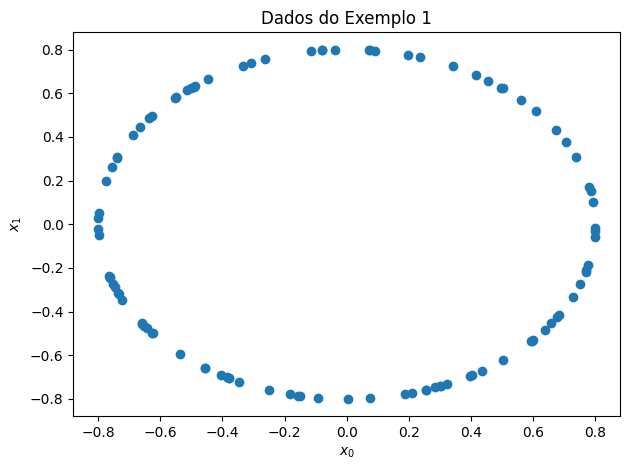

In [3]:
K = int(.5*1e6)
theta = 2*np.pi*np.random.random(K)
x0 = .8*np.sin(theta)
x1 = .8*np.cos(theta)

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.scatter(x0[:100], x1[:100])
ax0.set_xlabel('$x_0$')
ax0.set_ylabel('$x_1$')
ax0.set_title('Dados do Exemplo 1')
fig0.tight_layout()

### Treinamento

In [14]:
X = np.vstack((x0, x1))

2024-04-29 16:21:23.639693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)


Epoch 1/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6761 - val_loss: 0.1628
Epoch 2/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1622 - val_loss: 0.1607
Epoch 3/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1604 - val_loss: 0.1600
Epoch 4/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1600 - val_loss: 0.1599
Epoch 5/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1597 - val_loss: 0.1597
Epoch 6/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1591 - val_loss: 0.1324
Epoch 7/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1176 - val_loss: 0.0898
Epoch 8/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0831 - val_loss: 0.0691
Epoch 9/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0650 - val_loss: 0.0570
Epoch 10/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0543 - val_loss: 0.0500
Epoch 11/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0486 - val_loss: 0.0456
Epoch 12/250
1600/1

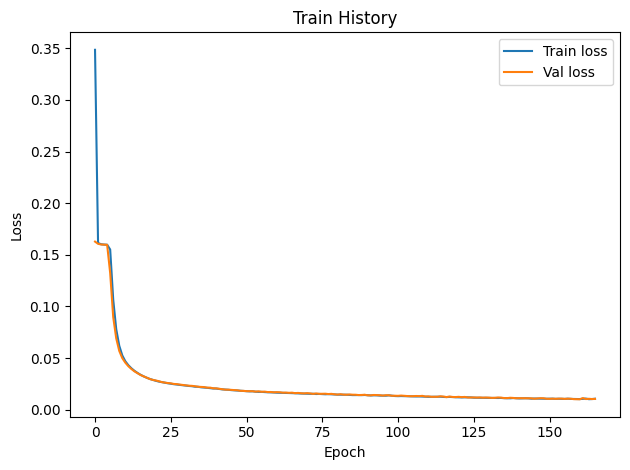

In [4]:
X = np.vstack((x0, x1))
nlpca_nn = NLPCA(num_variables=2, force_reduction=True)
pca = PCA(n_components=1)
pca.fit(X.T)
hist = nlpca_nn.fit(X.T, tune_flag=True)
# Plot train history
fig2 = plt.figure()
ax0 = fig2.add_subplot(111)
ax0.plot(hist['loss'], label='Train loss')
ax0.plot(hist['val_loss'], label='Val loss')
ax0.set_title('Train History')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend()
fig2.tight_layout()


docker run -it --gpus all --rm -p 8888:8888 -v "%cd%/storage:/mnt/storage" -w /mnt/storage nncpe727 jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root

### Teste

In [15]:
pca2 = PCA(n_components=2)
pca2.fit(X.T)

PCA(n_components=2)

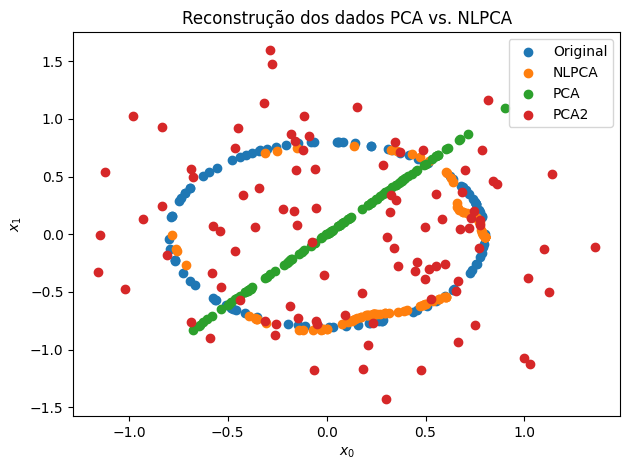

In [27]:
# Create test set:
K_test = 100
sigma_n2 = 1e-1  # Noise power
theta_test = 2*np.pi*np.random.random(K_test)
x0_test = .8*np.sin(theta_test)
x1_test = .8*np.cos(theta_test)
X_test = np.vstack((x0_test + np.sqrt(sigma_n2)*np.random.randn(K_test),
                    x1_test + np.sqrt(sigma_n2)*np.random.randn(K_test)))

# Test using trained models:
T = nlpca_nn.compress(X_test.T)
T_pca = pca.transform(X_test.T)
T_pca2 = pca2.transform(X_test.T)
X_hat = nlpca_nn.decompress(np.array(T))
X_hat_pca = pca.inverse_transform(T_pca)
X_hat_pca2 = pca2.inverse_transform(T_pca2)

# Plot results
fig1 = plt.figure()
ax0 = fig1.add_subplot(111)
ax0.scatter(x0_test, x1_test, label='Original')
ax0.scatter(X_hat[:, 0], X_hat[:, 1], label='NLPCA')
ax0.scatter(X_hat_pca[:, 0], X_hat_pca[:, 1], label='PCA')
ax0.scatter(X_hat_pca2[:, 0], X_hat_pca2[:, 1], label='PCA2')
ax0.set_xlabel('$x_0$')
ax0.set_ylabel('$x_1$')
ax0.set_title('Reconstrução dos dados PCA vs. NLPCA')
ax0.legend()
fig1.tight_layout()


In [28]:
X_test_noiseless = np.vstack((x0_test, x1_test))
print('NLPCA ', np.mean((X_test_noiseless.T-X_hat)**2))
print('PCA ', np.mean((X_test_noiseless.T-X_hat_pca)**2))
print('PCA2 ', np.mean((X_test_noiseless.T-X_hat_pca2)**2))

NLPCA  0.36630952
PCA  0.20046383829927414
PCA2  0.10296362968038883


## Exemplo 2

Aproximação por curvas principais. Nesse exemplo usamos curvas principais para aproximar um conjunto de dados não linear.

In [31]:
x = load_breast_cancer()

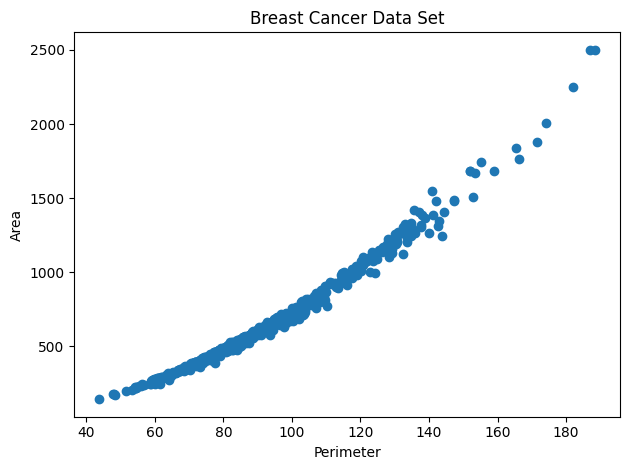

In [32]:
X = x['data'][:, (2, 3)]
fig2 = plt.figure()
ax0 = fig2.add_subplot(111)
ax0.scatter(X[:, 0], X[:, 1])
ax0.set_xlabel('Perimeter')
ax0.set_ylabel('Area')
ax0.set_title('Breast Cancer Data Set')
fig2.tight_layout()


0
inf
1
1.2653649420428321
2
5.038598512193832
3
1.516290960370231
4
21.698040065122694
5
20.978993930936568
6
4.35723941030743
7
0.7897566087349441
8
0.6859542016694299
9
0.6303613233540404
10
0.08179072956612836
11
0.0012819941632781114
12
0.00046286965001311395
13
0.0002823543822806137
14
0.0001332586307098496
15
9.22929175751104e-05
16
5.314243565032739e-05
17
3.680994481543472e-05
18
2.6962762608146937e-05
19
1.180970944433292e-05
20
1.3598814657365954e-06
21
1.5487683747289482e-07


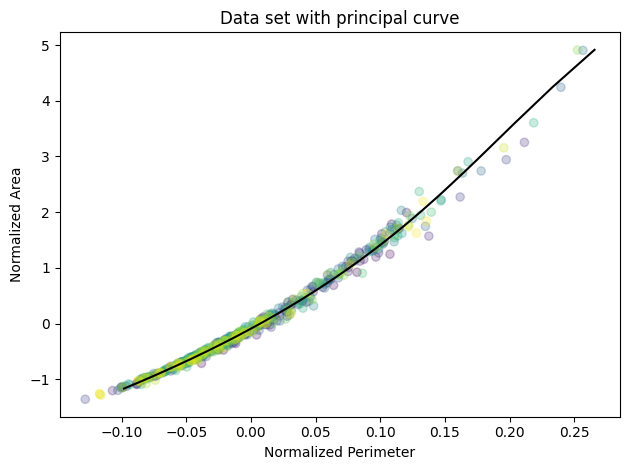

In [40]:
x_norm = (X - X.mean(axis=0))/X.std(ddof=0)

idx = np.arange(0, len(x_norm))
p = PrincipalCurve(k=3)
p.fit(x_norm, max_iter=40, tol=1e-6)

fig3 = plt.figure()
ax0 = fig3.add_subplot(111)
ax0.scatter(x_norm[:, 0], x_norm[:, 1], alpha=.25, c=idx)
ax0.plot(p.p[:, 0], p.p[:, 1], c='k')
ax0.set_xlabel('Normalized Perimeter')
ax0.set_ylabel('Normalized Area')
ax0.set_title('Data set with principal curve')
fig3.tight_layout()